**データへの確率分布の仮定**

1000gとして売っているパンの重量データは1000g付近を中心とした広がりを持つ連続値のデータ→1次元ガウス分布を仮定

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.stats import norm, gamma, t

data = pd.read_csv("input/bread-1000g-data.csv")
data.head()

,bread
0,942.6196
1,1009.8084
2,1042.9022
3,1009.2511
4,1028.6365


In [19]:
#平均、精度の理論値
x_n=data['bread'].values
mu_truth = np.mean(x_n)
lambda_truth = 1 / np.var(x_n)

**モデルの構築・学習**

1次元ガウス分布のパラメータは $\mu \in \mathbb{R}, \lambda \in \mathbb{R}^{+}$ であり、ともに未知なので共役事前分布としてガウス・ガンマ分布を採用

$\begin{aligned} p\left(\mu, \lambda\right) &=\operatorname{NG}\left(\mu, \lambda \mid m, \beta, a,b\right) \\ &=\mathcal{N}\left(\mu\mid m, (\beta\lambda)^{-1}\right)\operatorname{Gam}\left(\lambda\mid a,b\right) \end{aligned}$


今回は真のパラメータをもとにした1次元ガウス分布から発生したデータ系列$X_{n}$を学習させて

パラメータの事後分布を求めたいので平均値に関しては以下の1次元ガウス分布を求める

$p(\mu \mid \lambda, X)=\mathcal{N}\left(\mu \mid \hat{m},(\hat{\beta} \lambda)^{-1}\right)$  
$\hat{\beta}=N+\beta$ \\
$\hat{m}=\frac{1}{\widehat{\beta}}\left(\sum_{n=1}^{N} x_{n}+\beta m\right)$

また精度に関しては以下のガンマ分布を求める

$p(\lambda \mid X)=\operatorname{Gam}(\lambda \mid \hat{a}, \hat{b})$ \\
$\hat{a}=\frac{N}{2}+a$ \\
$\hat{b}=\frac{1}{2}\left(\sum_{n=1}^{N} x_{n}^{2}+\beta m^{2}-\hat{\beta} \hat{m}^{2}\right)+b$

In [20]:
#ランダムサンプリング
N=1000
x_n = np.random.normal(loc=mu_truth, scale=np.sqrt(1 / lambda_truth), size=N)

# 事前分布のパラメータを指定
beta=0
m = 1
a = 1
b = 1

# x軸の値を設定
mu_line = np.arange(900, 1100, 0.01)
lambda_line = np.linspace(0, 2 * lambda_truth, num=1000)
x_line = np.linspace(mu_truth - 4 * np.sqrt(1 / lambda_truth), mu_truth + 4 * np.sqrt(1 / lambda_truth), num=1000)

# ハイパーパラメータの計算
beta_hat = N + beta
m_hat = (np.sum(x_n) + beta * m) / beta_hat
a_hat = N/2 + a
b_hat = (np.sum(x_n**2) + beta * m**2 - beta_hat * m_hat**2) / 2 + b
lambda_hat = a_hat / b_hat

posterior_mu = norm.pdf(x=mu_line, loc=m_hat, scale=np.sqrt(1 / beta_hat / lambda_hat))
posterior_lambda = gamma.pdf(x=lambda_line, a=a_hat, scale=1 / b_hat)

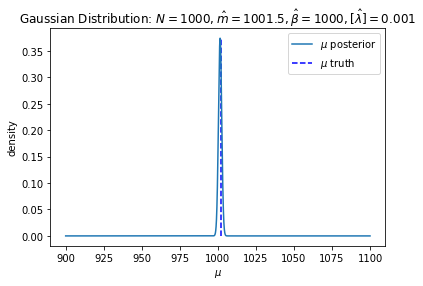

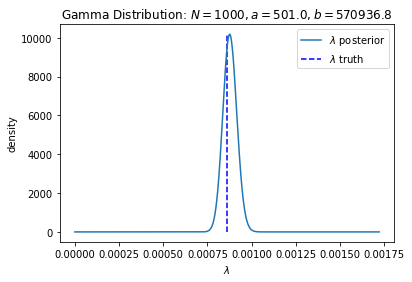

In [21]:
# 理論値と事後分布の描画
plt.figure()
plt.plot(mu_line, posterior_mu, label='$\mu$ posterior') 
plt.vlines(x=mu_truth, ymin=0, ymax=max(posterior_mu), label='$\mu$ truth', color='blue', linestyle='--') 
plt.xlabel('$\mu$')
plt.ylabel('density')
plt.title('Gaussian Distribution: $N=' + str(N) + ', \hat{m}=' + str(np.round(m_hat, 1)) + ', \hat{\\beta}=' + str(beta_hat) + ', [\hat{\lambda}]=' + str(np.round(lambda_hat, 3)) + '$')
plt.legend()
plt.show()

plt.figure()
plt.plot(lambda_line, posterior_lambda, label='$\lambda$ posterior')
plt.vlines(x=lambda_truth, ymin=0, ymax=max(posterior_lambda), label='$\lambda$ truth', color='blue', linestyle='--') 
plt.xlabel('$\lambda$')
plt.ylabel('density')
plt.title('Gamma Distribution: $N=' + str(N) + ', a=' + str(a_hat) + ', b=' + str(np.round(b_hat, 1)) + '$')
plt.legend()
plt.show()

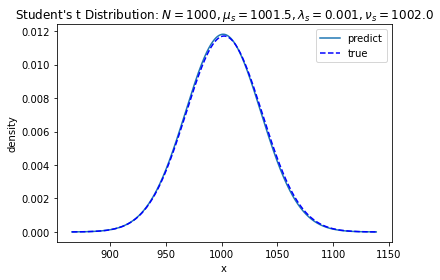

In [22]:
#予測分布の計算
mu_s = m_hat
lambda_s = beta_hat * a_hat / (1 + beta_hat) / b_hat
nu_s = 2 * a_hat

true_model = norm.pdf(x=x_line, loc=mu_truth, scale=np.sqrt(1 / lambda_truth))
predict = t.pdf(x=x_line, df=nu_s, loc=mu_s, scale=np.sqrt(1 / lambda_s))

plt.figure()
plt.plot(x_line, predict, label='predict') 
plt.plot(x_line, true_model, label='true', color='blue', linestyle='--')
plt.xlabel('x')
plt.ylabel('density')
plt.title('Student\'s t Distribution: $N=' + str(N) + ', {\mu}_s=' + str(np.round(mu_s, 1)) + ', {\lambda}_s=' + str(np.round(lambda_s, 3)) + ', {\\nu}_s=' + str(nu_s) + '$')
plt.legend()
plt.show()